<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [2]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
# !pip install ./deepul
from deepul.hw2_helper import *

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import math
import os
from typing import Type, Any, Callable, Union, List, Optional



/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
@torch.no_grad()
def test_loss(model, test_loader, loss_dim=1) -> Union[float, List[float]]:
    '''
    Take either a DataLoader, return the average loss over the whole test set.
    test_loader should be generated in the device.
    '''
    model.eval()
    loss = [0 for _ in range(loss_dim)]
    for count, X in enumerate(test_loader):
        X = X.to(device)
        tmp = model.loss(X) # Assume loss() returns a dict or a tuple
        if isinstance(tmp, dict):
            tmp = list(tmp.values())
        elif isinstance(tmp, torch.Tensor):
            tmp = [tmp]
        for i in range(loss_dim):
            loss[i] += tmp[i].item()
    if loss_dim == 1:
        return loss[0] / (count + 1)
    else:
        return [l / (count + 1) for l in loss]

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


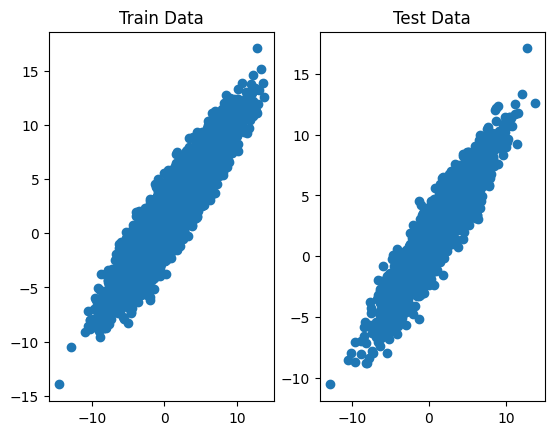

Dataset 2


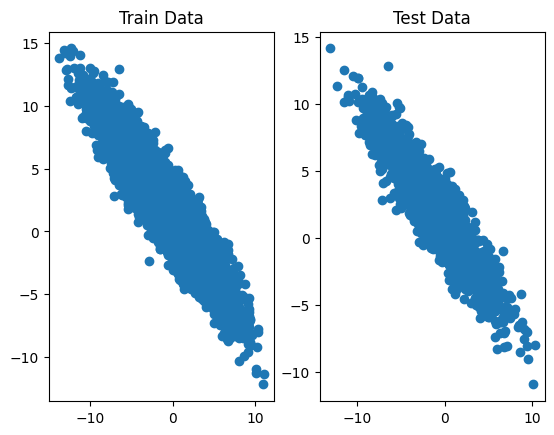

In [4]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




In [22]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, z_dim=2, hidden_dim=100):   # z_dim 需要设置成一个比较小的值，否则其成像并不好
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim * 2)
        )

    def encode(self, x):
        z_params = self.encoder(x)
        z_mean, z_log_var = z_params.chunk(2, dim=-1)
        return z_mean, z_log_var

    def decode(self, z):
        x_params = self.decoder(z)
        x_mean, x_log_var = x_params.chunk(2, dim=-1)
        return x_mean, x_log_var

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean, x_log_var = self.decode(z)
        x_hat = self.reparameterize(x_mean, x_log_var)
        return x_hat, x_mean, x_log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def loss(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean, x_log_var = self.decode(z)
        

        # KL 
        kl = 0.5 * torch.sum(z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1, dim=-1)
        # reconstruction loss


        pi = torch.tensor(np.log(2 * np.pi), dtype=x.dtype, device=x.device)
        rcl = 0.5 * torch.sum((x - x_mean) ** 2 / torch.exp(x_log_var) + x_log_var + pi, dim=-1)
        kl, rcl = kl.mean(), rcl.mean()
        nelbo = kl + rcl 
        return nelbo, rcl.mean(), kl.mean()

    @torch.no_grad()
    def sample(self, n):
        z = torch.randn(n, 2).to(device)
        x_mean, x_log_std = self.decode(z)
        return self.reparameterize(x_mean, x_log_std), x_mean

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [23]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    lr, epochs, batch_size = 0.01, 10, 128
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    record_train, record_test = [], [test_loss(model, test_loader, loss_dim=3)]

    for epoch in range(epochs):
        print(f"epoch : {epoch}", end = "     ")
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            nelbo, kl, rcl = model.loss(x)
            nelbo.backward()
            optimizer.step()
            record_train.append([nelbo.item(), kl.item(), rcl.item()])
        record_test.append(test_loss(model, test_loader, loss_dim=3))
        print(f"loss : {record_test[-1][0]}")
    samples_noisy, samples_clean = model.sample(1000)

    return np.array(record_train), np.array(record_test), samples_noisy.cpu().numpy(), samples_clean.cpu().numpy()



### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

epoch : 0     loss : 5.371648550033569
epoch : 1     loss : 4.985501909255982
epoch : 2     loss : 4.541808438301087
epoch : 3     loss : 4.484034848213196
epoch : 4     loss : 4.577199578285217
epoch : 5     loss : 4.479967641830444
epoch : 6     loss : 4.446178650856018
epoch : 7     loss : 4.457692551612854
epoch : 8     loss : 4.501443529129029
epoch : 9     loss : 4.489038968086243
Final -ELBO: 4.4890, Recon Loss: 2.9342, KL Loss: 1.5548


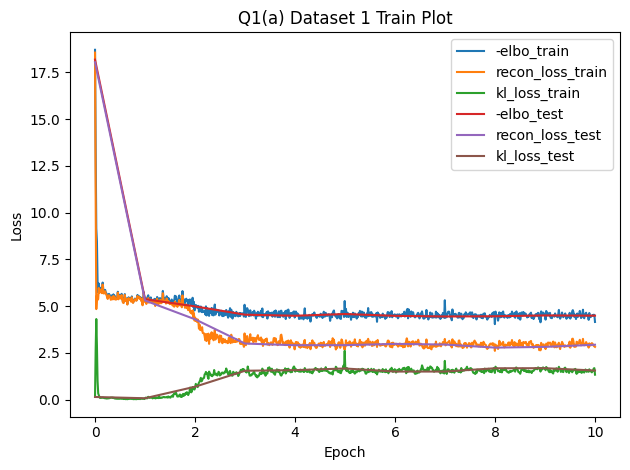

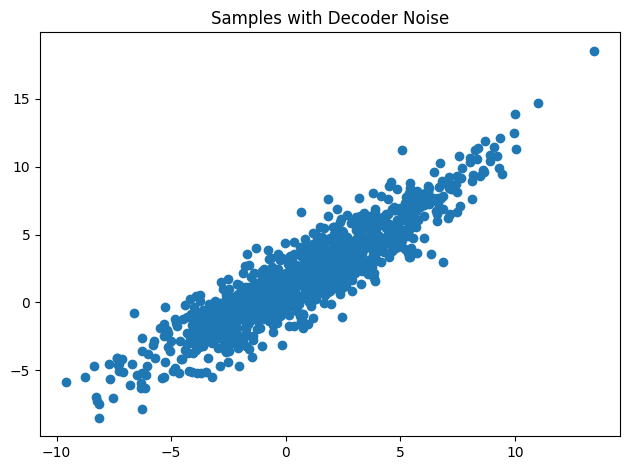

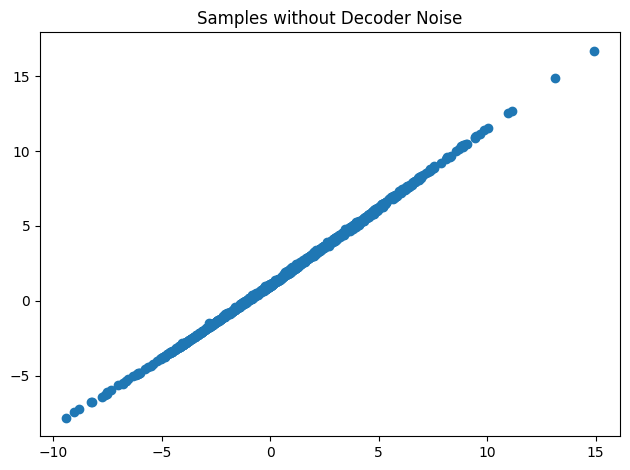

In [24]:
q1_save_results('a', 1, q1)

epoch : 0     loss : 5.199324893951416
epoch : 1     loss : 4.5139507293701175
epoch : 2     loss : 4.5333446025848385
epoch : 3     loss : 4.497468042373657
epoch : 4     loss : 4.478063941001892
epoch : 5     loss : 4.486901116371155
epoch : 6     loss : 4.451857113838196
epoch : 7     loss : 4.486901569366455
epoch : 8     loss : 4.48956081867218
epoch : 9     loss : 4.491091990470887
Final -ELBO: 4.4911, Recon Loss: 2.9395, KL Loss: 1.5516


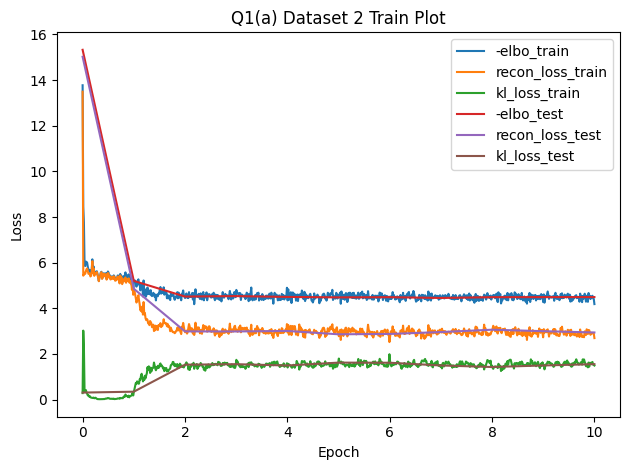

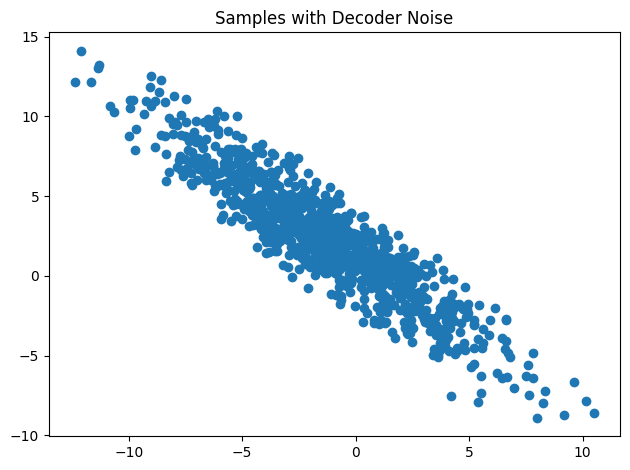

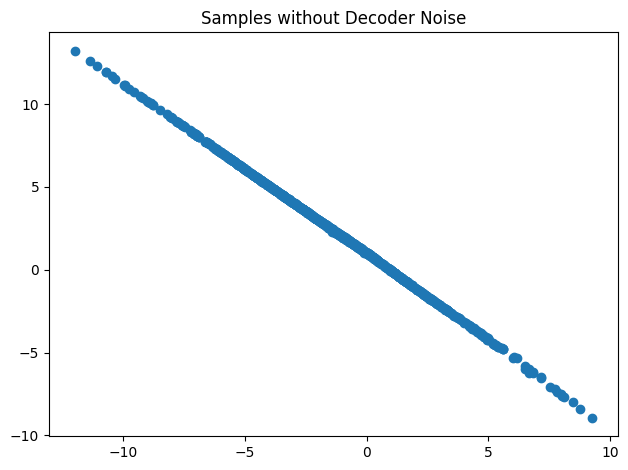

In [13]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


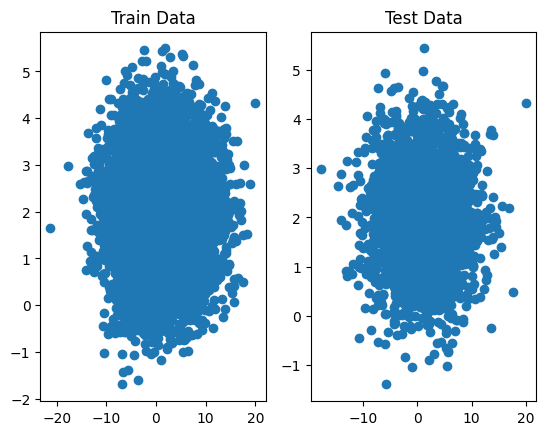

Dataset 2


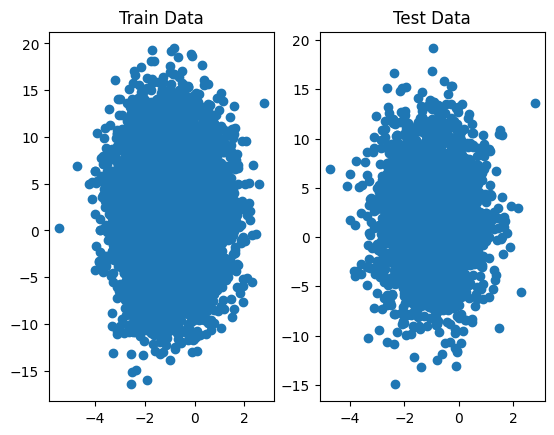

In [25]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

epoch : 0     loss : 4.44439594745636
epoch : 1     loss : 4.43195481300354
epoch : 2     loss : 4.438290691375732
epoch : 3     loss : 4.513581848144531
epoch : 4     loss : 4.423867869377136
epoch : 5     loss : 4.4593181133270265
epoch : 6     loss : 4.437877130508423
epoch : 7     loss : 4.432677936553955
epoch : 8     loss : 4.443203496932983
epoch : 9     loss : 4.43309862613678
Final -ELBO: 4.4331, Recon Loss: 4.4301, KL Loss: 0.0030


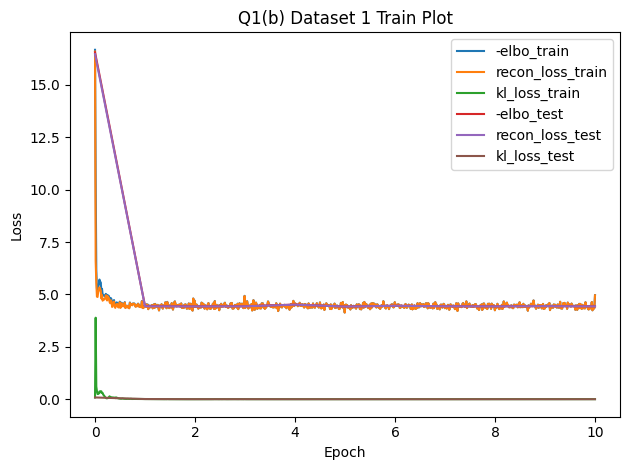

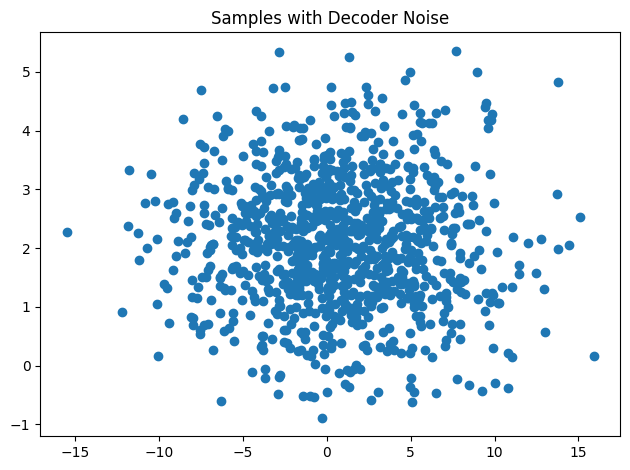

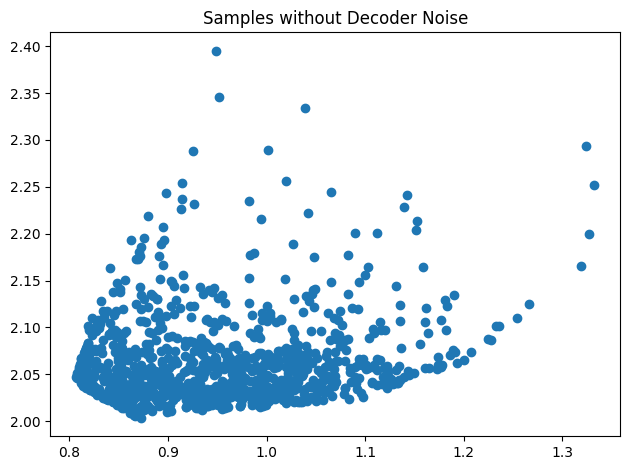

In [26]:
q1_save_results('b', 1, q1)

epoch : 0     loss : 4.457914090156555
epoch : 1     loss : 4.428833842277527
epoch : 2     loss : 4.452672171592712
epoch : 3     loss : 4.424802041053772
epoch : 4     loss : 4.437257575988769
epoch : 5     loss : 4.4515204429626465
epoch : 6     loss : 4.419117784500122
epoch : 7     loss : 4.447366642951965
epoch : 8     loss : 4.426300406455994
epoch : 9     loss : 4.434075498580933
Final -ELBO: 4.4341, Recon Loss: 4.4338, KL Loss: 0.0003


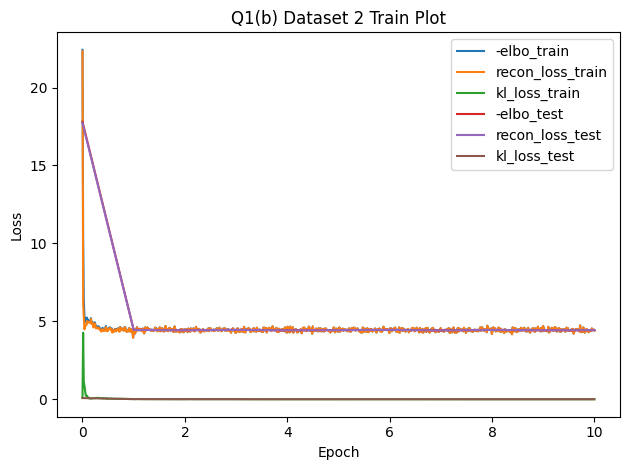

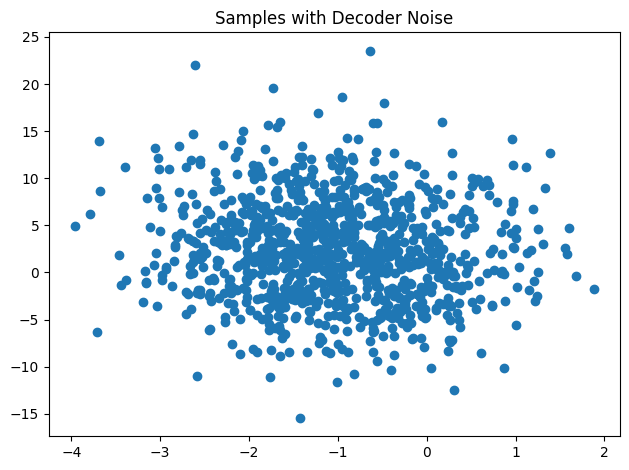

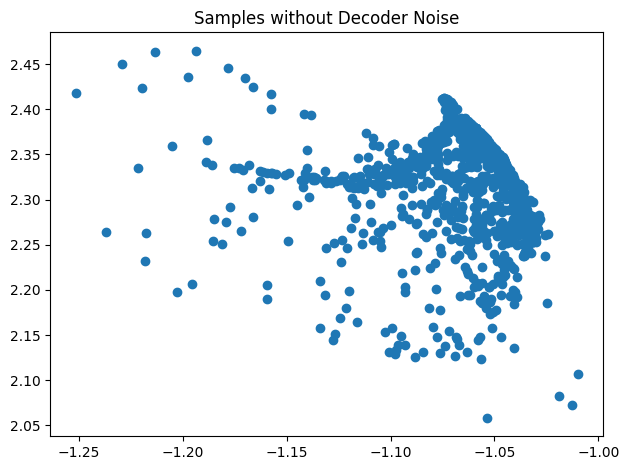

In [27]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

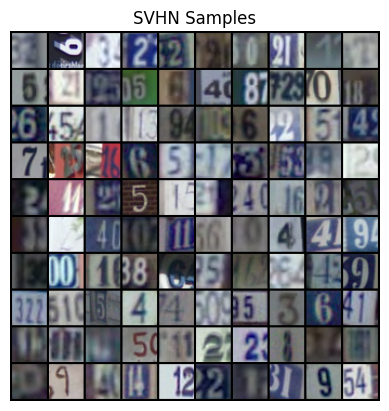

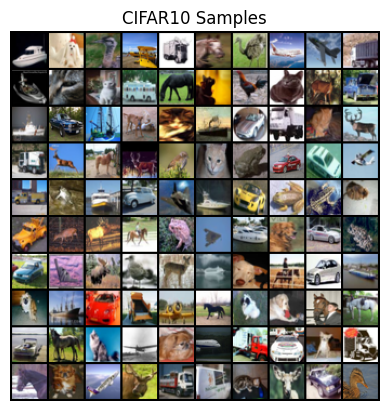

In [28]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [64]:
class VanillaVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super().__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 4, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=4,
                                       stride = 2,
                                       padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=4,
                                               stride=2,
                                               padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
            Encodes the input by passing through the encoder network
            and returns the latent codes.
            input : (B, C, H, W)
            return : (B, latent_dim)
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
            z : (B, latent_dim)
            return : (B, 3, 32, 32)
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss(self, x) -> dict:
        """
        
        """
        args  = self.forward(x)
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        # 重建损失函数
        # VanillaVAE的并不同
        recons_loss = 0.5 * torch.mean(torch.sum((x - recons) ** 2, dim = [1, 2, 3]), dim = 0)

        # KL散度损失函数
        kld_loss = 0.5 * torch.mean(torch.sum(mu ** 2 + log_var.exp() - 1 - log_var, dim = 1), dim = 0)

        loss = recons_loss + kld_loss
        return (loss, recons_loss, kld_loss)


    @torch.no_grad()
    def sample(self,
               num_samples:int):

        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(device)

        samples = self.decode(z)

        return samples

    @torch.no_grad()
    def reconstruct(self, x):

        B, C, W, H = x.shape
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean = self.decode(z)

        # 因为我们的数据范围是在[-1, 1]，所以直接加N(0, 1)的噪声是相当大的，所以我们修改系数将其转化为较小的噪声
        x_hat = x_mean + 0.001 * torch.randn_like(x_mean)

        result = torch.zeros(B * 2, C, W, H)
        result[::2] = x
        result[1::2] = x_hat

        return result

    @torch.no_grad()
    def interpolate(self, x, y):
        """generate 10 interpolations between x and y
            x: (10, C, H, W)
            y: (10, C, H, W)
        """
        z_mean_x, z_log_var_x = self.encode(x)
        z_mean_y, z_log_var_y = self.encode(y)
        _, C, H, W = x.shape
        result = torch.zeros(10, 10, C, H, W)
        for i in range(10):
            z_mean = z_mean_x + (z_mean_y - z_mean_x) * i / 9
            z_log_var = z_log_var_x + (z_log_var_y - z_log_var_x) * i / 9
            z = self.reparameterize(z_mean, z_log_var)
            x_mean = self.decode(z)
            x_hat = x_mean + 0.001 * torch.randn_like(x_mean)
            result[i] = x_hat
        result = result.permute(1, 0, 2, 3, 4) 
        result = result.reshape(100, C, H, W)
        return result

In [8]:
def preprocess(x):
    x = torch.tensor(x, dtype = torch.float32).permute(0, 3, 1, 2)
    x = (x / 255) * 2 - 1   # (-1, 1)
    return x

def postprocess(x):
    x = x.cpu().numpy()
    x = (np.clip(x, -1, 1) + 1) / 2 * 255
    x = x.astype(np.int16).transpose(0, 2, 3, 1)
    return x

In [72]:
import test


def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    lr, epochs, batch_size = 0.001, 60, 128
    model = VanillaVAE(in_channels = 3, latent_dim = 16).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    record_train, record_test = [], [test_loss(model, test_loader, loss_dim=3)]


    # checkpoints = torch.load(os.path.join(
    #         'Checkpoints', 'ckpt_' + 'VanillaVAE' + ".pt"))
    
    # model.load_state_dict(checkpoints["model"])
    # record_train = checkpoints["train_losses"]
    # record_test = checkpoints["test_losses"]
    
    

    for epoch in range(epochs):
        model.train()
        print(f"epoch : {epoch}", end = "    ")
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            nelbo, rcl, kl = model.loss(x)
            # nelbo.backward()
            nelbo.backward()
            optimizer.step()
            record_train.append([nelbo.item(), rcl.item(), kl.item()])
        record_test.append(test_loss(model, test_loader, loss_dim=3))
        print(f"loss : {record_test[-1][0]}")
        checkpoint = {
            "model" : model.state_dict(),
            "train_losses" : record_train,
            "test_losses" : record_test
        }
        torch.save(checkpoint, os.path.join(
            'Checkpoints', 'ckpt_' + 'VanillaVAE_cifar_10' + ".pt"))
    samples = postprocess(model.sample(100))
    pairs = postprocess(model.reconstruct(test_data[:50, :, :, :].to(device)))
    interpolations = postprocess(model.interpolate(test_data[:10].to(device), test_data[10:20].to(device)))

    return np.array(record_train), np.array(record_test), samples, pairs, interpolations

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

epoch : 0    loss : 115.00121936798095
epoch : 1    loss : 83.91009693145752
epoch : 2    loss : 79.00852394104004
epoch : 3    loss : 74.3843376159668
epoch : 4    loss : 70.7444330215454
epoch : 5    loss : 68.23820180892945
epoch : 6    loss : 67.63609561920165
epoch : 7    loss : 67.38247938156128
epoch : 8    loss : 69.68474454879761
epoch : 9    loss : 65.91192855834962
epoch : 10    loss : 66.46022548675538
epoch : 11    loss : 67.07272176742553
epoch : 12    loss : 77.06298904418945
epoch : 13    loss : 67.37928247451782
epoch : 14    loss : 64.31825332641601
epoch : 15    loss : 64.28236322402954
epoch : 16    loss : 63.652462005615234
epoch : 17    loss : 64.98763780593872
epoch : 18    loss : 63.539141750335695
epoch : 19    loss : 65.51479539871215
epoch : 20    loss : 65.78571472167968
epoch : 21    loss : 63.027280235290526
epoch : 22    loss : 63.74835052490234
epoch : 23    loss : 63.25964231491089
epoch : 24    loss : 63.6599347114563
epoch : 25    loss : 64.3105423927

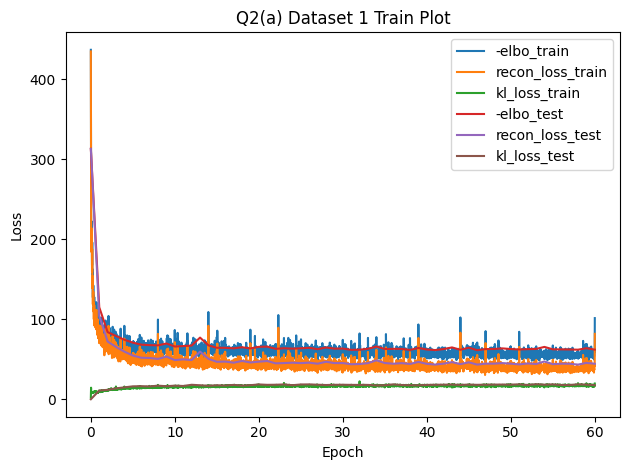

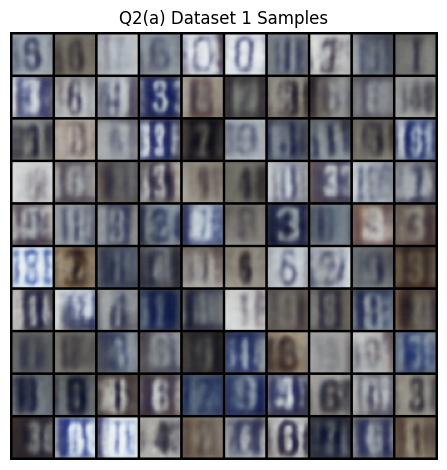

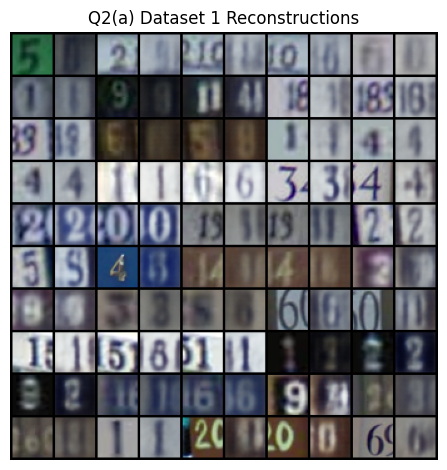

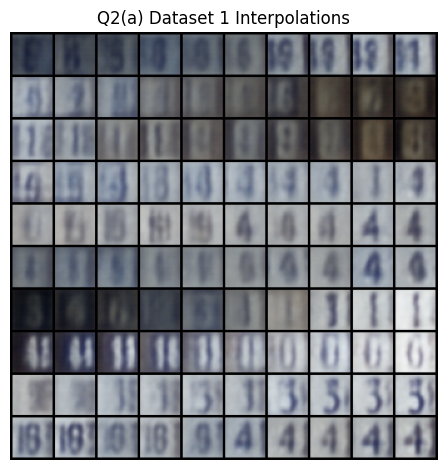

In [71]:
q2_save_results('a', 1, q2_a)

epoch : 0    loss : 142.6654788632936
epoch : 1    loss : 138.88033091871046
epoch : 2    loss : 139.85066532183296
epoch : 3    loss : 136.66971597792227
epoch : 4    loss : 134.75133108790916
epoch : 5    loss : 134.05220620843428
epoch : 6    loss : 134.99082125893122
epoch : 7    loss : 134.29119177709651
epoch : 8    loss : 133.6026167084899
epoch : 9    loss : 133.7200556887856
epoch : 10    loss : 134.09002675889414
epoch : 11    loss : 132.86029574237293
epoch : 12    loss : 133.4753093478046
epoch : 13    loss : 132.60902028144162
epoch : 14    loss : 133.58678677715832
epoch : 15    loss : 132.93386029593552
epoch : 16    loss : 134.0518677144111
epoch : 17    loss : 132.01905272278606
epoch : 18    loss : 132.35820673689057
epoch : 19    loss : 133.66049203993398
epoch : 20    loss : 132.4292517553402
epoch : 21    loss : 133.85240723815144
epoch : 22    loss : 131.63848432709898
epoch : 23    loss : 131.57196778888945
epoch : 24    loss : 131.3074512723126
epoch : 25    los

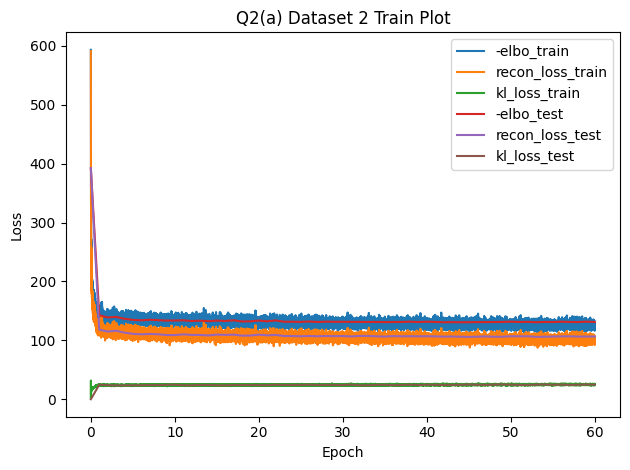

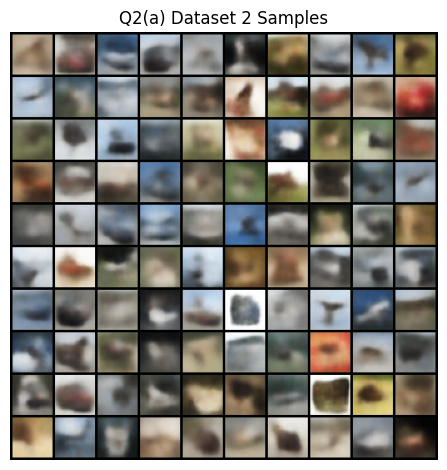

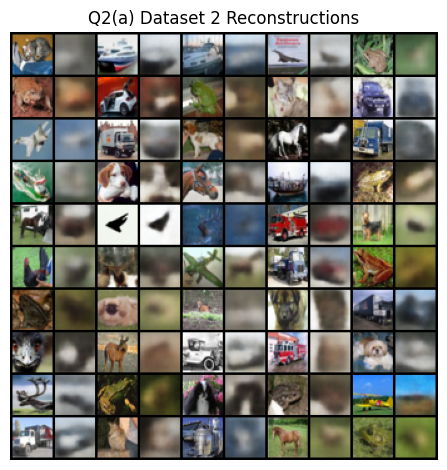

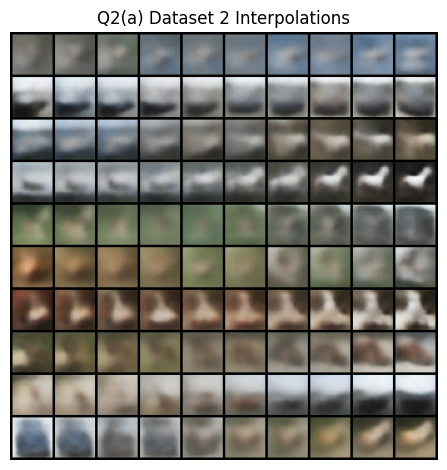

In [73]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [18]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, channels):
        '''
            对通道维度进行归一化
        '''
        super().__init__(channels)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 1, 2)
        return x

class Hencoder(nn.Module):
    def __init__(self, input_channels=3+12):
        '''
            对于二次的encode时，需要添加x作为条件，如果不需要，则会设置x为空
        '''
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1), # [32, 32, 32]
            LayerNorm(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
            LayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
        )

    def forward(self, x, z=None):
        if z is not None:
            z = F.interpolate(z, size=(x.shape[2], x.shape[3]), mode='nearest')
            x = torch.cat([x, z], dim=1)
        return self.encoder(x)

class Hdecoder(nn.Module):
    def __init__(self):

        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
        )

    def forward(self, z):
        return self.decoder(z)

class HVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Hencoder(3) 
        self.rnd_z2 = Hencoder(3+12) 
        self.priori_z2 = Hencoder(3+12) 
        self.decoder = Hdecoder()

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def encode(self, x):
        lst = []

        # z1
        z1_params = self.encoder(x)
        z1_mean, z1_log_var = z1_params.chunk(2, dim=1)
        z1 = self.reparameterize(z1_mean, z1_log_var)
        lst.append((z1, z1_mean, z1_log_var))

        # z2
        zeros_x = torch.zeros(x.shape[0], 3, x.shape[2], x.shape[3]).to(device)
        priori_z2_params = self.priori_z2(zeros_x, z1)
        priori_z2_mean, priori_z2_log_var = priori_z2_params.chunk(2, dim=1)

        res_z2_params = self.rnd_z2(x, z1)
        res_z2_mean, res_z2_log_var = res_z2_params.chunk(2, dim=1)

        # 我们假设priori_z2_var是恒等于1的，所以只需要保证res_z2_var为1
        z2_mean, z2_log_var = res_z2_mean + priori_z2_mean, res_z2_log_var
        z2 = self.reparameterize(z2_mean, z2_log_var)
        lst.append((z2, priori_z2_mean, priori_z2_log_var, res_z2_mean, res_z2_log_var))


        return lst



    def decode(self, z2):
        return self.decoder(z2)

    def loss(self, x):
        z_lst = self.encode(x)
        z1, z1_mean, z1_log_var = z_lst[0]
        z2, _, priori_z2_log_var, res_z2_mean, res_z2_log_var = z_lst[1]
        x_mean = self.decode(z2)


        # z1 N(0, 1)
        kl_z1 = 0.5 * torch.sum(z1_mean ** 2 + torch.exp(z1_log_var) - z1_log_var - 1, dim=[1, 2, 3])

        # 两种用于限制z2分布的方式
        kl_residual = 0.5 * torch.sum(res_z2_mean ** 2  + torch.exp(res_z2_log_var) - res_z2_log_var - 1, dim=[1, 2, 3])
        # kl_residual = 0.5 * torch.sum(res_z2_log_var - 1 + (1 + res_z2_mean ** 2) / torch.exp(res_z2_log_var), dim = (1, 2, 3))

        # reconstruction loss
        recons_loss = 0.5 * torch.sum((x - x_mean) ** 2, dim=[1, 2, 3]) 
        
        kl_z1, kl_residual, rcl = kl_z1.mean(), kl_residual.mean(), recons_loss.mean()
        nelbo = kl_z1 + kl_residual + recons_loss 

        
        return nelbo, recons_loss, kl_z1 + kl_residual

    @torch.no_grad()
    def sample(self, n):
        z1 = torch.randn(n, 12, 2, 2).to(device)
        zeros_x = torch.zeros(n, 3, 32, 32).to(device)
        priori_z2_params = self.priori_z2(zeros_x, z1)
        priori_z2_mean, priori_z2_log_var = priori_z2_params.chunk(2, dim=1)

        z2 = priori_z2_mean + torch.randn_like(priori_z2_mean)
        
        x_mean = self.decode(z2)
        return x_mean

    @torch.no_grad()
    def reconstruct(self, x):

        B, C, W, H = x.shape
        z_lst = self.encode(x)
        z2, _, _, _, _ = z_lst[1]
        x_mean = self.decode(z2)


        result = torch.zeros(B * 2, C, W, H)
        result[::2] = x
        result[1::2] = x_mean

        return result

    @torch.no_grad()
    def interpolate(self, x, y):
        """generate 10 interpolations between x and y
        args:
            x: (10, C, H, W)
            y: (10, C, H, W)
        """
        x_z_lst = self.encode(x)
        y_z_lst = self.encode(y)
        x_z2 = x_z_lst[1][0]
        y_z2 = y_z_lst[1][0]
        _, C, H, W = x.shape
        result = torch.zeros(10, 10, C, H, W)
        for i in range(10):
            z2 = x_z2 + (y_z2 - x_z2) * i / 9
            x_mean = self.decode(z2)
            x_hat = x_mean + 0.001 * torch.randn_like(x_mean)
            result[i] = x_hat
        result = result.permute(1, 0, 2, 3, 4) # To fit with the HW2 helper function
        result = result.reshape(100, C, H, W)
        return result

In [20]:
def q2_b(train_data, test_data, dset_id):
  """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

  """ YOUR CODE HERE """
  
  lr, epochs, batch_size = 0.001, 30, 128
  model = HVAE().to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_data = preprocess(train_data)
  test_data = preprocess(test_data)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  record_train, record_test = [], [test_loss(model, test_loader, loss_dim=3)]


  # checkpoints = torch.load(os.path.join(
  #         'Checkpoints', 'ckpt_' + 'HVAE_svhn' + ".pt"))
  
  # model.load_state_dict(checkpoints["model"])
  # record_train = checkpoints["train_losses"]
  # record_test = checkpoints["test_losses"]
  
  

  for epoch in range(epochs):
      model.train()
      print(f"epoch : {epoch}", end = "    ")
      for x in train_loader:
          x = x.to(device)
          optimizer.zero_grad()
          nelbo, rcl, kl = model.loss(x)
          # nelbo.backward()
          nelbo.backward()
          optimizer.step()
          record_train.append([nelbo.item(), rcl.item(), kl.item()])
      record_test.append(test_loss(model, test_loader, loss_dim=3))
      print(f"loss : {record_test[-1][0]}")
      checkpoint = {
          "model" : model.state_dict(),
          "train_losses" : record_train,
          "test_losses" : record_test
      }
      torch.save(checkpoint, os.path.join(
          'Checkpoints', 'ckpt_' + 'HVAE_cifar_10' + ".pt"))
  
  samples = postprocess(model.sample(100))
  pairs = postprocess(model.reconstruct(test_data[:50, :, :, :].to(device)))
  interpolations = postprocess(model.interpolate(test_data[:10].to(device), test_data[10:20].to(device)))

  return np.array(record_train), np.array(record_test), samples, pairs, interpolations


### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

epoch : 0    loss : 203.38735160827636
epoch : 1    loss : 154.84530944824218
epoch : 2    loss : 120.92099666595459
epoch : 3    loss : 105.56572971343994
epoch : 4    loss : 111.35404357910156
epoch : 5    loss : 106.80440883636474
epoch : 6    loss : 93.08284034729004
epoch : 7    loss : 89.5856252670288
epoch : 8    loss : 87.07306003570557
epoch : 9    loss : 88.25920276641845
epoch : 10    loss : 84.60241947174072
epoch : 11    loss : 84.39593753814697
epoch : 12    loss : 81.85776309967041
epoch : 13    loss : 83.72618503570557
epoch : 14    loss : 81.27700328826904
epoch : 15    loss : 81.50220546722412
epoch : 16    loss : 79.22667026519775
epoch : 17    loss : 81.57262516021729
epoch : 18    loss : 78.03584270477295
epoch : 19    loss : 77.571994972229
epoch : 20    loss : 75.26818618774413
epoch : 21    loss : 75.64932632446289
epoch : 22    loss : 74.90708408355712
epoch : 23    loss : 75.79011898040771
epoch : 24    loss : 72.91491012573242
epoch : 25    loss : 72.67992458

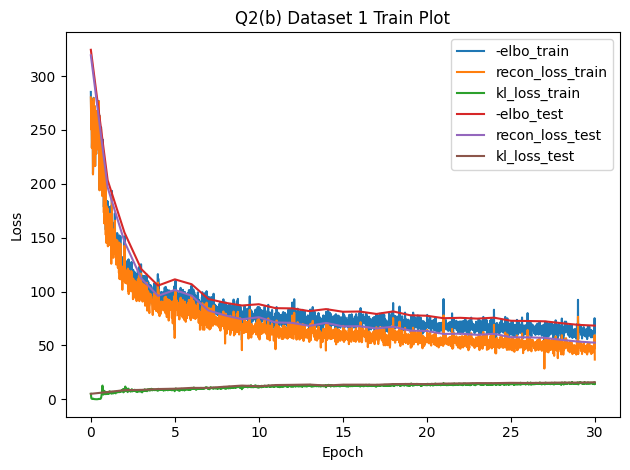

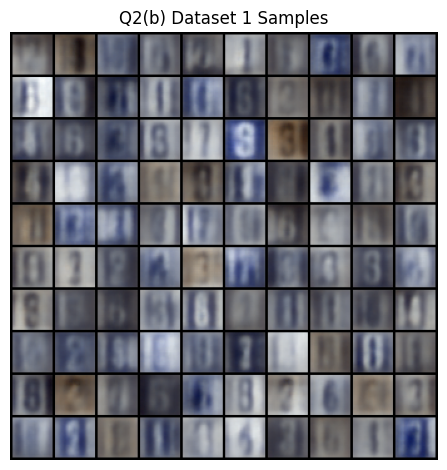

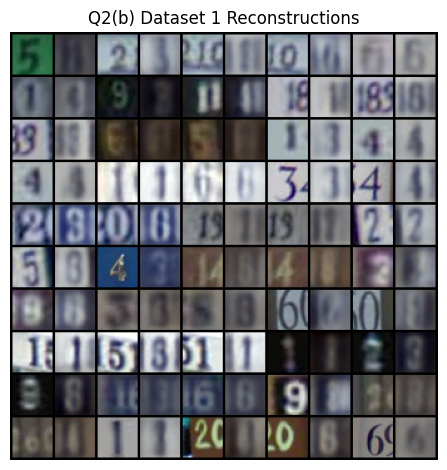

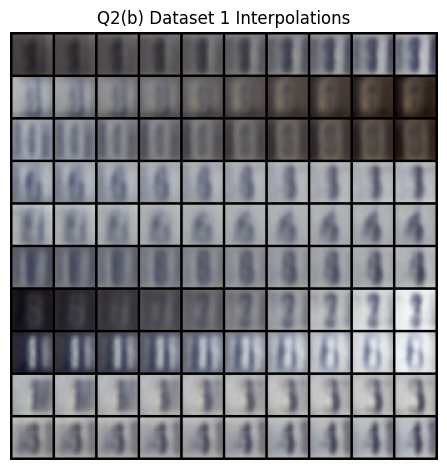

In [19]:
q2_save_results('b', 1, q2_b)

epoch : 0    loss : 181.50669416596617
epoch : 1    loss : 163.78032790558248
epoch : 2    loss : 155.1770761224288
epoch : 3    loss : 144.3903841429119
epoch : 4    loss : 137.64566069011445
epoch : 5    loss : 137.25668634342242
epoch : 6    loss : 134.0059046684941
epoch : 7    loss : 132.25380822676647
epoch : 8    loss : 131.17995752262163
epoch : 9    loss : 129.54980768131304
epoch : 10    loss : 129.44395321230346
epoch : 11    loss : 129.35773303840733
epoch : 12    loss : 128.81395151645322
epoch : 13    loss : 128.46877578542203
epoch : 14    loss : 127.40551709525192
epoch : 15    loss : 126.92180546627769
epoch : 16    loss : 127.46597096889833
epoch : 17    loss : 125.5455409182778
epoch : 18    loss : 125.67454094222829
epoch : 19    loss : 124.9070714636694
epoch : 20    loss : 125.16259746310077
epoch : 21    loss : 126.05455104006997
epoch : 22    loss : 124.30348244196252
epoch : 23    loss : 123.96347789522967
epoch : 24    loss : 124.8307673780224
epoch : 25    lo

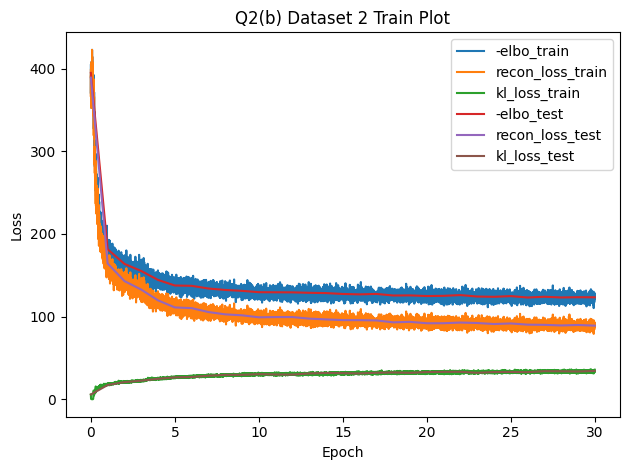

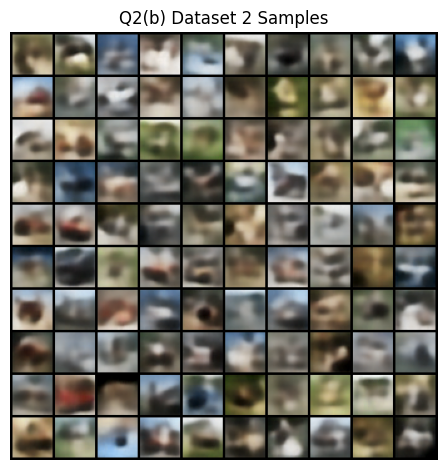

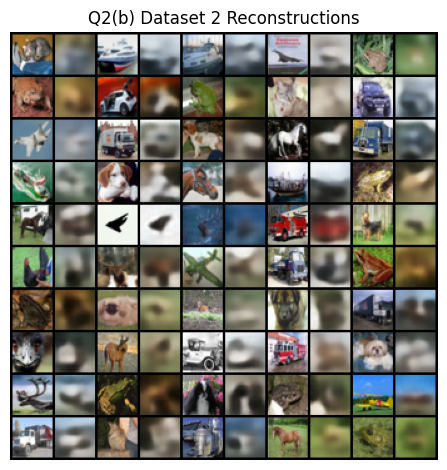

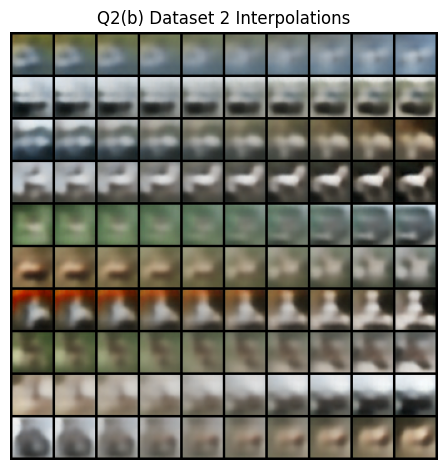

In [21]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [27]:
@torch.no_grad()
def test_loss(model, test_loader) -> float :
  model.eval()
  loss, count = 0, 0
  with torch.no_grad():
    for x in test_loader:
      x = x.to(device)
      loss += model.loss(x).item()
      count += 1
  return loss / count


In [63]:
from torch.nn.modules.batchnorm import BatchNorm2d

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            BatchNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            BatchNorm2d(dim), nn.ReLU(),
            nn.Conv2d(dim, dim, 1, 1, ),
        )

    def forward(self, x):
        return x + self.net(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1), # 16 x 16
            BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 4, 2, 1), # 8 x 8
            ResidualBlock(256),
            ResidualBlock(256),
        )

    def forward(self, x):
        return self.net(x) # (B, 256, 8, 8)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 4, 2, 1), # 16 x 16
            BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 3, 4, 2, 1), # 32 x 32
        )

    def forward(self, x):
        return self.net(x)

class LatentQuantizer(nn.Module):
    def __init__(self, K=128, D=256):
        super().__init__()
        self.K = K
        self.D = D
        self.codebook = nn.Parameter(- 1 / K + 2 / K *
            torch.randn((K, D)))

    def forward(self, z):
        z_q = z.permute(0, 2, 3, 1).unsqueeze(-1) # (B, H, W, D, 1)
        distance = z_q - torch.transpose(self.codebook, -2, -1) # (B, H, W, D, K)
        distance = torch.sum(distance ** 2, dim=-2) # (B, H, W, K)
        z_q = torch.argmin(distance, dim=-1) # (B, H, W)
        return z_q # (B, H, W)

    def decode(self, z_q):
        return self.codebook[z_q].permute(0, 3, 1, 2)

class VQVAE(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.quantizer = LatentQuantizer(K, D)

    def quantized_encode(self, x):
        z_e = self.encoder(x) # (B, 256, 8, 8)
        z_d = self.quantizer(z_e) # (B, 8, 8)
        z_dict = {'z_e': z_e, 'z_d': z_d}
        return z_dict

    def decode(self, z_dict):
        z_e, z_d = z_dict.values()
        z_q = self.quantizer.decode(z_d)
        
        x_hat = self.decoder((z_q - z_e).detach() + z_e)
        return x_hat

    def forward(self, x):
        z_dict = self.quantized_encode(x)
        x_hat = self.decode(z_dict)
        return x_hat

    def loss(self, x, beta=0.25):

        z_dict = self.quantized_encode(x)
        z_e, z_d = z_dict['z_e'], z_dict['z_d'] # (B, 256, 8, 8), (B, 8, 8)
        z_q = self.quantizer.decode(z_d) # (B, 256, 8, 8)

        loss1 = F.mse_loss(z_e.detach(), z_q)
        loss2 = F.mse_loss(z_e, z_q.detach())

        x_hat = self.decode(z_dict)
        recons_loss = F.mse_loss(x, x_hat)

        losses = loss1 + loss2 + recons_loss
        return losses

    @torch.no_grad()
    def quantize(self, x):
        z_dict = self.quantized_encode(x)
        z_d = z_dict['z_d']
        return z_d

    @torch.no_grad()
    def sample(self, n, prior_model=None):
        
        if prior_model is None:
            # 此采样下是无效的，因为这样的初始化可能并不是一张图像
            z_d = torch.randint(0, 128, (n, 8, 8)).to(device)
        else:
            flatten_z_q = prior_model.sample(numbers = n) # (n, 8 * 8)
            z_d = flatten_z_q.reshape(n, 8, 8)
        z_q = self.quantizer.decode(z_d)
        x_hat = self.decoder(z_q)
        return x_hat

    @torch.no_grad()
    def reconstruct(self, x):
        x_hat = self.forward(x)

        B, C, H, W = x.shape

        result = torch.zeros(B * 2, C, H, W)
        result[::2] = x
        result[1::2] = x_hat
        return result

In [65]:
def append_bos(x, bos):

    B, L = x.shape
    Bos = torch.full((B, 1), bos, dtype = torch.long).to(device)
    return torch.cat([Bos, x], dim = 1)


class vqvae_DataLoader(DataLoader):
    '''
        (1) quantize the image from (B, C, H, W) -> (B, 7, 7)
        (2) append the bos
    '''
    
    def __init__(self, vqvae, data, batch_size, shuffle = True, num_workers = 4, bos = 0):
        super().__init__(data, batch_size, shuffle = shuffle, num_workers = num_workers)
        self.bos = bos
        self.vqvae = vqvae

    def __iter__(self):
        for x in super().__iter__():
            B, C, W, _ = x.shape
            x = x.to(device)
            vec = self.vqvae.quantize(x) # (B, 8, 8)
            vec = vec.reshape(B, 8 * 8)
            vec = torch.tensor(vec, dtype = torch.long)
            vec = append_bos(vec, self.bos) # (B, 8 * 8 + 1)
            yield vec  # (B, L)
               

class Embedding(nn.Module):
    def __init__(self, L, vocal_size, dmodel):
        super().__init__()
        self.L = L
        self.vocal_size = vocal_size
        self.embedding = nn.Embedding(vocal_size, dmodel)
        self.embedding_pos = nn.Embedding(L, dmodel) #位置编码

    def forward(self, x):
        pos = torch.arange(self.L).long().to(device)
        
        pos_emb = self.embedding_pos(pos)
        
        Y = self.embedding(x) + pos_emb
 
        return Y # (B, L, dmodel)

class Attention(nn.Module):
    def __init__(self, L, dmodel, dim):
        super().__init__()
        self.q = nn.Linear(dmodel, dim)
        self.k = nn.Linear(dmodel, dim)
        self.v = nn.Linear(dmodel, dim)
        self.scale = dmodel ** (-0.5)
        self.register_buffer('tril', torch.tril(torch.ones((L, L))))

    def forward(self, x):

        ''' X : (B, L, dmodel)'''

        
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        W = q @ k.transpose(-1, -2) * self.scale # (B, L, L)
        W = W.masked_fill(self.tril == 0, float('-inf'))
        W = F.softmax(W, dim = -1)
        ans = W @ v
        return ans # (B, L, dim)


class MutiAttention(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.layers = nn.ModuleList([Attention(L, dmodel, dim) for _ in range(n_head)])

    def forward(self, x):
        X = [layer(x) for layer in self.layers]
        return torch.cat(X, dim = -1) # (B, L, dim * n_head)


class TransformerBlock(nn.Module):
    def __init__(self, L, dmodel, dim, n_head):
        super().__init__()
        self.Attention = MutiAttention(L, dmodel, dim, n_head)
        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)
        self.mlp = nn.Sequential(nn.Linear(dmodel, dmodel), nn.GELU())

    def forward(self, x):

        '''X : (B, L, dmodel)'''

        x = self.Attention(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x  # (B, L, dmodel)


class iGPT(nn.Module):
    def __init__(self, L, dmodel, vocal_size, n_layer, n_head, bos):

        super().__init__()
        self.embedding = Embedding(L, vocal_size, dmodel)

        assert dmodel % n_head == 0
        self.transformer = nn.Sequential(*[TransformerBlock(L, dmodel, dmodel // n_head, n_head) for _ in range(n_layer)])
        self.fc = nn.Linear(dmodel, vocal_size)
        self.L = L
        self.dmodel = dmodel
        self.bos = bos

    def forward(self, x):

        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)

        return x # (B, L, vocal_size)

    def loss(self, x):

        '''X : (B, L)'''
        B, L = x.shape
        X = self.forward(x) # (B, L, vocal_size)
        pred = X[:, : -1, :].reshape(B * (L - 1), -1) # (B * (L - 1), vocal_size)
        target = x[:, 1:].flatten() #(B * (L - 1))
        
        return F.cross_entropy(pred, target)

    @torch.no_grad()
    def sample(self, numbers):
        
        print(numbers)
        samples = torch.zeros((numbers, self.L)).long().to(device)
        samples[:, 0] = self.bos
        steps = self.L - 1

        for i in range(steps):
            
            prob = self.forward(samples)[:, i, : -1]
            # print(prob.shape)
            prob = F.softmax(prob, dim = -1)
            # print(torch.multinomial(prob, 1).squeeze().shape)
            # print(samples[:, i + 1].shape)
            samples[:, i + 1] = torch.multinomial(prob, 1).squeeze()   # (100)

        return samples[:, 1:] # (B,  L - 1)


In [70]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    lr, epochs, batch_size, K, D = 0.001, 30, 128, 128, 256
    vqvae = VQVAE(K, D).to(device)
    optimizer = optim.Adam(vqvae.parameters(), lr=lr)
    train_data = preprocess(train_data)
    test_data = preprocess(test_data)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    vqvae_trainlosses, vqvae_testlosses = [], [test_loss(vqvae, test_loader)]    

    # checkpoints = torch.load(os.path.join(
    #       'Checkpoints', 'ckpt_' + 'vqvae' + ".pt"))
  
    # vqvae.load_state_dict(checkpoints["model"])
    # vqvae_trainlosses = checkpoints["vqvae_trainlosses"]
    # vqvae_testlosses = checkpoints["vqvae_testlosses"]


    for epoch in range(epochs):
        vqvae.train()
        print(f"epoch : {epoch}", end = "    ")
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            nelbo = vqvae.loss(x)
            # nelbo.backward()
            nelbo.backward()
            optimizer.step()
            vqvae_trainlosses.append(nelbo.item())
        vqvae_testlosses.append(test_loss(vqvae, test_loader))

        checkpoint = {
          "model" : vqvae.state_dict(),
          "vqvae_trainlosses" : vqvae_trainlosses,
          "vqvae_testlosses" : vqvae_testlosses
        } 
        torch.save(checkpoint, os.path.join(
            'Checkpoints', 'ckpt_' + 'vqvae' + ".pt"))


        print(f"loss : {vqvae_testlosses[-1]}")


    dmodel, n_head, n_layer = 128, 4, 2 # 转换到的空间维度，多头注意力机制的头数，transformer的层数
    L = 8 * 8 + 1 # 字符的长度 
    vocal_size = 128 + 1 # 词的值的范围{0-2} values in {0, 1} bos = 2 
    bos = 128 # 开始符的值

    lr, epochs, batch_size = 5*1e-3, 20, 128


    model = iGPT(L, dmodel, vocal_size, n_layer, n_head, bos).to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    print(train_data.shape)
    train_loader = vqvae_DataLoader(vqvae, train_data, batch_size, shuffle = True, bos = bos)
    test_loader = vqvae_DataLoader(vqvae, test_data, batch_size, shuffle = True, bos = bos)
    iGPT_trainlosses, iGPT_testlosses, samples = [], [test_loss(model, test_loader)], []


    # checkpoints = torch.load(os.path.join(
    #       'Checkpoints', 'ckpt_' + 'vqvae_iGPT' + ".pt"))
  
    # model.load_state_dict(checkpoints["model"])
    # iGPT_trainlosses = checkpoints["iGPT_trainlosses"]
    # iGPT_testlosses = checkpoints["iGPT_testlosses"]

    for _ in range(epochs):

        print(f"epoch:{_}")
        model.train()
        
        for x in train_loader:
                
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            iGPT_trainlosses.append(loss.item())
            # print(train_losses[-1])
            
        iGPT_testlosses.append(test_loss(model, test_loader))
        print(f"loss:{iGPT_testlosses[-1]}")

        checkpoint = {
          "model" : model.state_dict(),
          "iGPT_trainlosses" : iGPT_trainlosses,
          "iGPT_testlosses" : iGPT_testlosses
        } 
        torch.save(checkpoint, os.path.join(
            'Checkpoints', 'ckpt_' + 'vqvae_iGPT' + ".pt"))

    samples = postprocess(vqvae.sample(100, prior_model = model))
    pairs = postprocess(vqvae.reconstruct(test_data[: 50, :, :, :].to(device)))

    return np.array(vqvae_trainlosses), np.array(vqvae_testlosses), np.array(iGPT_trainlosses), np.array(iGPT_testlosses), samples, pairs


## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

torch.Size([10000, 3, 32, 32])


/tmp/ipykernel_37174/3909035262.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vec = torch.tensor(vec, dtype = torch.long)


100
100
VQ-VAE Final Test Loss: 0.0252
Transformer Prior Final Test Loss: 1.8902


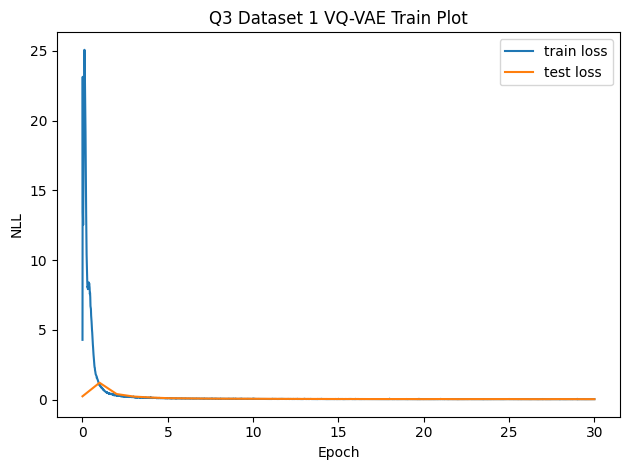

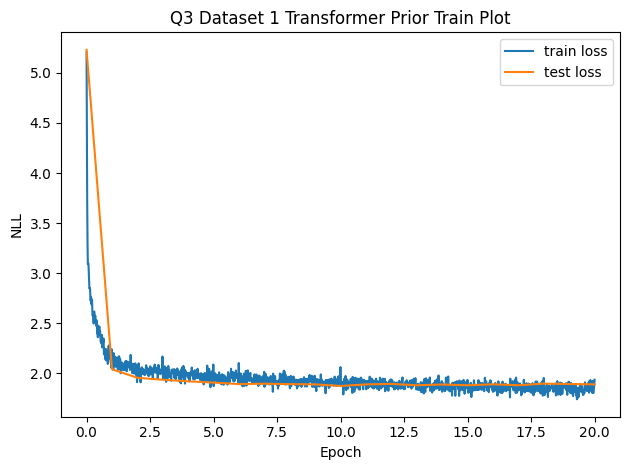

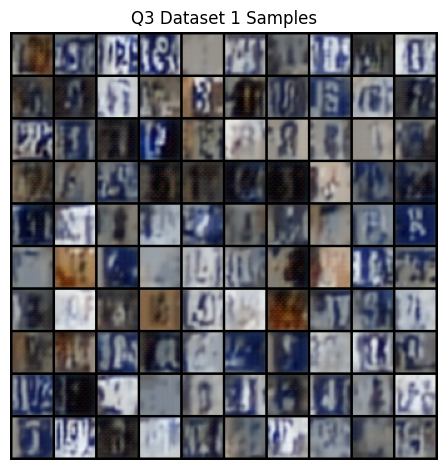

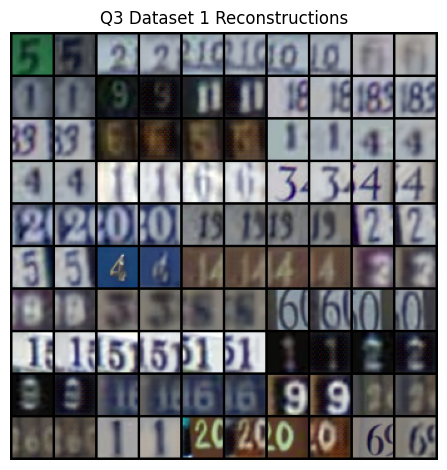

In [69]:
q3_save_results(1, q3)

epoch : 0    loss : 0.15042277416096458
epoch : 1    loss : 0.08995466452987888
epoch : 2    loss : 0.07692040399282793
epoch : 3    loss : 0.07443999857464924
epoch : 4    loss : 0.07163650448186488
epoch : 5    loss : 0.07304715959331658
epoch : 6    loss : 0.07004269344519966
epoch : 7    loss : 0.06782482592742654
epoch : 8    loss : 0.06602702072904079
epoch : 9    loss : 0.06456105760003947
epoch : 10    loss : 0.06473729693436925
epoch : 11    loss : 0.06269604269462296
epoch : 12    loss : 0.06230883300304413
epoch : 13    loss : 0.06745753140200543
epoch : 14    loss : 0.06447222097953663
epoch : 15    loss : 0.07211813868223867
epoch : 16    loss : 0.06330276884232895
epoch : 17    loss : 0.0653248457591745
epoch : 18    loss : 0.05898604956986029
epoch : 19    loss : 0.06454710747244992
epoch : 20    loss : 0.06032920227963713
epoch : 21    loss : 0.059954107986598074
epoch : 22    loss : 0.05951455480690244
epoch : 23    loss : 0.055494112917516804
epoch : 24    loss : 0.05

/tmp/ipykernel_37174/3909035262.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vec = torch.tensor(vec, dtype = torch.long)


epoch:0
loss:3.00523302223109
epoch:1
loss:2.9835559295702585
epoch:2
loss:2.9686189301406283
epoch:3
loss:2.9570966400677645
epoch:4
loss:2.9488125571721717
epoch:5
loss:2.9451623113849497
epoch:6
loss:2.94132791591596
epoch:7
loss:2.936705127547059
epoch:8
loss:2.9339084595064575
epoch:9
loss:2.9305807065360154
epoch:10
loss:2.9268171244029757
epoch:11
loss:2.9248600911490525
epoch:12
loss:2.9223496883730347
epoch:13
loss:2.9217217511768583
epoch:14
loss:2.920959753326223
epoch:15
loss:2.9244766899302035
epoch:16
loss:2.9201168983797485
epoch:17
loss:2.9215518854841402
epoch:18
loss:2.9208488826510273
epoch:19
loss:2.9212071412726295
100
100
VQ-VAE Final Test Loss: 0.0525
Transformer Prior Final Test Loss: 2.9212


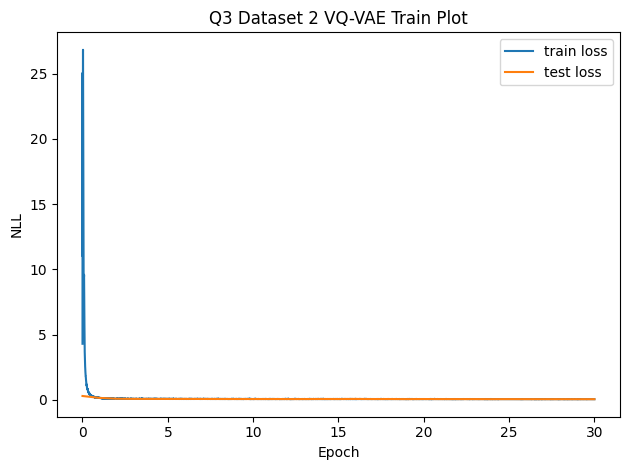

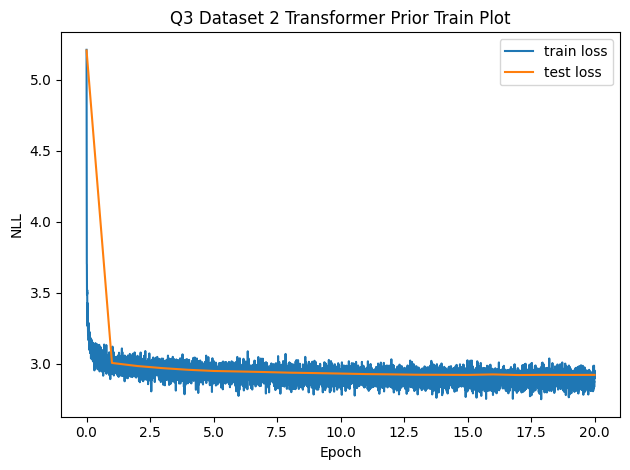

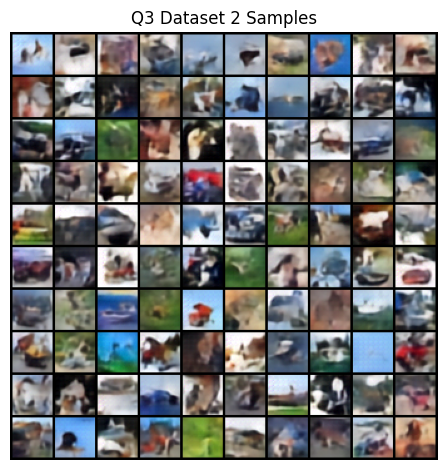

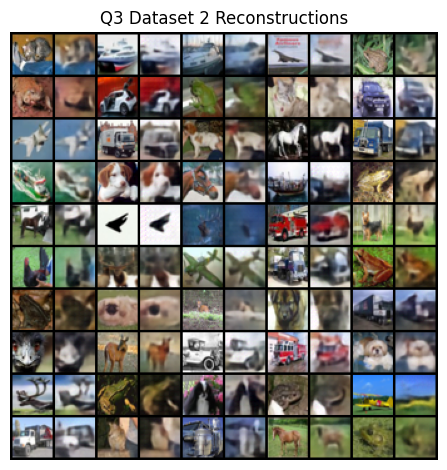

In [71]:
q3_save_results(2, q3)